# Regression in Python

***
This is a very quick run-through of some basic statistical concepts, adapted from [Lab 4 in Harvard's CS109](https://github.com/cs109/2015lab4) course. Please feel free to try the original lab if you're feeling ambitious :-) The CS109 git repository also has the solutions if you're stuck.

* Linear Regression Models
* Prediction using linear regression

Linear regression is used to model and predict continuous outcomes with normal random errors. There are nearly an infinite number of different types of regression models and each regression model is typically defined by the distribution of the prediction errors (called "residuals") of the type of data. Logistic regression is used to model binary outcomes whereas Poisson regression is used to predict counts. In this exercise, we'll see some examples of linear regression as well as Train-test splits.

The packages we'll cover are: `statsmodels`, `seaborn`, and `scikit-learn`. While we don't explicitly teach `statsmodels` and `seaborn` in the Springboard workshop, those are great libraries to know.
***

<img width=600 height=300 src="https://imgs.xkcd.com/comics/sustainable.png"/>
***

In [219]:
# special IPython command to prepare the notebook for matplotlib and other libraries
%matplotlib inline 

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.feature_selection import f_regression

import seaborn as sns

# special matplotlib argument for improved plots
from matplotlib import rcParams
sns.set_style("whitegrid")
sns.set_context("poster")

***
# Part 1: Introduction to Linear Regression
### Purpose of linear regression
***
<div class="span5 alert alert-info">

<p> Given a dataset containing predictor variables $X$ and outcome/response variable $Y$, linear regression can be used to: </p>
<ul>
  <li> Build a <b>predictive model</b> to predict future values of $\hat{Y}$, using new data $X^*$ where $Y$ is unknown.</li>
  <li> Model the <b>strength of the relationship</b> between each independent variable $X_i$ and $Y$</li>
    <ul>
      <li> Many times, only a subset of independent variables $X_i$ will have a linear relationship with $Y$</li>
      <li> Need to figure out which $X_i$ contributes most information to predict $Y$ </li>
    </ul>
   <li>It is in many cases, the first pass prediction algorithm for continuous outcomes. </li>
</ul>
</div>

### A Brief Mathematical Recap
***

[Linear Regression](http://en.wikipedia.org/wiki/Linear_regression) is a method to model the relationship between a set of independent variables $X$ (also knowns as explanatory variables, features, predictors) and a dependent variable $Y$.  This method assumes the relationship between each predictor $X$ is **linearly** related to the dependent variable $Y$. The most basic linear regression model contains one independent variable $X$, we'll call this the simple model. 

$$ Y = \beta_0 + \beta_1 X + \epsilon$$

where $\epsilon$ is considered as an unobservable random variable that adds noise to the linear relationship. In linear regression, $\epsilon$ is assumed to be normally distributed with a mean of 0. In other words, what this means is that on average, if we know $Y$, a roughly equal number of predictions $\hat{Y}$ will be above $Y$ and others will be below $Y$. That is, on average, the error is zero. The residuals, $\epsilon$ are also assumed to be "i.i.d.": independently and identically distributed. Independence means that the residuals are not correlated -- the residual from one prediction has no effect on the residual from another prediction. Correlated errors are common in time series analysis and spatial analyses.

* $\beta_0$ is the intercept of the linear model and represents the average of $Y$ when all independent variables $X$ are set to 0.

* $\beta_1$ is the slope of the line associated with the regression model and represents the average effect of a one-unit increase in $X$ on $Y$.

* Back to the simple model. The model in linear regression is the *conditional mean* of $Y$ given the values in $X$ is expressed a linear function.  

$$ y = f(x) = E(Y | X = x)$$ 

![conditional mean](images/conditionalmean.png)
http://www.learner.org/courses/againstallodds/about/glossary.html

* The goal is to estimate the coefficients (e.g. $\beta_0$ and $\beta_1$). We represent the estimates of the coefficients with a "hat" on top of the letter.  

$$ \hat{\beta}_0, \hat{\beta}_1 $$

* Once we estimate the coefficients $\hat{\beta}_0$ and $\hat{\beta}_1$, we can use these to predict new values of $Y$ given new data $X$.

$$\hat{y} = \hat{\beta}_0 + \hat{\beta}_1 x_1$$

* Multiple linear regression is when you have more than one independent variable and the estimation involves matrices
    * $X_1$, $X_2$, $X_3$, $\ldots$


* How do you estimate the coefficients? 
    * There are many ways to fit a linear regression model
    * The method called **least squares** is the most common methods
    * We will discuss least squares

$$ Y = \beta_0 + \beta_1 X_1 + \ldots + \beta_p X_p + \epsilon$$ 
    
### Estimating $\hat\beta$: Least squares
***
[Least squares](http://en.wikipedia.org/wiki/Least_squares) is a method that can estimate the coefficients of a linear model by minimizing the squared residuals: 

$$ \mathscr{L} = \sum_{i=1}^N \epsilon_i = \sum_{i=1}^N \left( y_i - \hat{y}_i \right)^2  = \sum_{i=1}^N \left(y_i - \left(\beta_0 + \beta_1 x_i\right)\right)^2 $$

where $N$ is the number of observations and $\epsilon$ represents a residual or error, ACTUAL - PREDICTED.  

#### Estimating the intercept $\hat{\beta_0}$ for the simple linear model

We want to minimize the squared residuals and solve for $\hat{\beta_0}$ so we take the partial derivative of $\mathscr{L}$ with respect to $\hat{\beta_0}$ 

$
\begin{align}
\frac{\partial \mathscr{L}}{\partial \hat{\beta_0}} &= \frac{\partial}{\partial \hat{\beta_0}} \sum_{i=1}^N \epsilon^2 \\
&= \frac{\partial}{\partial \hat{\beta_0}} \sum_{i=1}^N \left( y_i - \hat{y}_i \right)^2 \\
&= \frac{\partial}{\partial \hat{\beta_0}} \sum_{i=1}^N \left( y_i - \left( \hat{\beta}_0 + \hat{\beta}_1 x_i \right) \right)^2 \\
&= -2 \sum_{i=1}^N \left( y_i - \left( \hat{\beta}_0 + \hat{\beta}_1 x_i \right) \right) \hspace{25mm} \mbox{(by chain rule)} \\
&= -2 \sum_{i=1}^N y_i - \hat{\beta}_0 - \hat{\beta}_1 x_i \\
&= -2 \left[ \left( \sum_{i=1}^N y_i \right) - n \hat{\beta_0} - \hat{\beta}_1 \left( \sum_{i=1}^N x_i
\right) \right] \\
& 2 \left[ n \hat{\beta}_0 + \hat{\beta}_1 \sum_{i=1}^N x_i - \sum_{i=1}^N y_i \right] = 0 \hspace{20mm} \mbox{(Set equal to 0 and solve for $\hat{\beta}_0$)} \\
& n \hat{\beta}_0 + \hat{\beta}_1 \sum_{i=1}^N x_i - \sum{i=1}^N y_i = 0 \\
& n \hat{\beta}_0 = \sum_{i=1}^N y_i - \hat{\beta}_1 \sum_{i=1}^N x_i \\
& \hat{\beta}_0 = \frac{\sum_{i=1}^N y_i - \hat{\beta}_1 \sum_{i=1}^N x_i}{n} \\
& \hat{\beta}_0 = \frac{\sum_{i=1}^N y_i}{n} - \hat{\beta}_1 \frac{\sum_{i=1}^N x_i}{n} \\
& \boxed{\hat{\beta}_0 = \bar{y} - \hat{\beta}_1 \bar{x}}
\end{align}
$

Using this new information, we can compute the estimate for $\hat{\beta}_1$ by taking the partial derivative of $\mathscr{L}$ with respect to $\hat{\beta}_1$.

$
\begin{align}
\frac{\partial \mathscr{L}}{\partial \hat{\beta_1}} &= \frac{\partial}{\partial \hat{\beta_1}} \sum_{i=1}^N \epsilon^2 \\
&= \frac{\partial}{\partial \hat{\beta_1}} \sum_{i=1}^N \left( y_i - \hat{y}_i \right)^2 \\
&= \frac{\partial}{\partial \hat{\beta_1}} \sum_{i=1}^N \left( y_i - \left( \hat{\beta}_0 + \hat{\beta}_1 x_i \right) \right)^2 \\
&= 2 \sum_{i=1}^N \left( y_i - \left( \hat{\beta}_0 + \hat{\beta}_1 x_i \right) \right) \left( -x_i \right) \hspace{25mm}\mbox{(by chain rule)} \\
&= -2 \sum_{i=1}^N x_i \left( y_i - \hat{\beta}_0 - \hat{\beta}_1 x_i \right) \\
&= -2 \sum_{i=1}^N x_i y_i - \hat{\beta}_0 x_i - \hat{\beta}_1 x_i^2 \\
&= -2 \sum_{i=1}^N x_i y_i - \left( \bar{y} - \hat{\beta}_1 \bar{x} \right) x_i - \hat{\beta}_1 x_i^2 \\
&= -2 \sum_{i=1}^N x_i y_i - \bar{y}x_i + \hat{\beta}_1\bar{x}x_i - \hat{\beta}_1 x_i^2 \\
&= -2 \left[ \sum_{i=1}^N x_i y_i - \bar{y} \sum_{i=1}^N x_i + \hat{\beta}_1\bar{x} - \hat{\beta}_1 x_i^2 \right] \\
&= -2 \left[ \hat{\beta}_1 \left\{ \bar{x} \sum_{i=1}^N x_i - \sum_{i=1}^N x_i^2 \right\} + \left\{ \sum_{i=1}^N x_i y_i - \bar{y} \sum_{i=1}^N x_i \right\}\right] \\
& 2 \left[ \hat{\beta}_1 \left\{ \sum_{i=1}^N x_i^2 - \bar{x} \sum_{i=1}^N x_i \right\} + \left\{ \bar{y} \sum_{i=1}^N x_i - \sum_{i=1}^N x_i y_i \right\} \right] = 0 \\
& \hat{\beta}_1 = \frac{-\left( \bar{y} \sum_{i=1}^N x_i - \sum_{i=1}^N x_i y_i \right)}{\sum_{i=1}^N x_i^2 - \bar{x}\sum_{i=1}^N x_i} \\
&= \frac{\sum_{i=1}^N x_i y_i - \bar{y} \sum_{i=1}^N x_i}{\sum_{i=1}^N x_i^2 - \bar{x} \sum_{i=1}^N x_i} \\
& \boxed{\hat{\beta}_1 = \frac{\sum_{i=1}^N x_i y_i - \bar{x}\bar{y}n}{\sum_{i=1}^N x_i^2 - n \bar{x}^2}}
\end{align}
$

The solution can be written in compact matrix notation as

$$\hat\beta =  (X^T X)^{-1}X^T Y$$ 

We wanted to show you this in case you remember linear algebra, in order for this solution to exist we need $X^T X$ to be invertible. Of course this requires a few extra assumptions, $X$ must be full rank so that $X^T X$ is invertible, etc. Basically, $X^T X$ is full rank if all rows and columns are linearly independent. This has a loose relationship to variables and observations being independent respective. **This is important for us because this means that having redundant features in our regression models will lead to poorly fitting (and unstable) models.** We'll see an implementation of this in the extra linear regression example.

***
# Part 2: Exploratory Data Analysis for Linear Relationships

The [Boston Housing data set](https://archive.ics.uci.edu/ml/datasets/Housing) contains information about the housing values in suburbs of Boston.  This dataset was originally taken from the StatLib library which is maintained at Carnegie Mellon University and is now available on the UCI Machine Learning Repository. 


## Load the Boston Housing data set from `sklearn`
***

This data set is available in the [sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html#sklearn.datasets.load_boston) python module which is how we will access it today.  

In [35]:
from sklearn.datasets import load_boston
import pandas as pd

boston = load_boston()

In [36]:
boston.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR'])

In [37]:
boston.data.shape

(506, 13)

In [38]:
# Print column names
print(boston.feature_names)

['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


In [39]:
# Print description of Boston housing data set
print(boston.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

Now let's explore the data set itself. 

In [40]:
bos = pd.DataFrame(boston.data)
bos.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


There are no column names in the DataFrame. Let's add those. 

In [41]:
bos.columns = boston.feature_names
bos.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


Now we have a pandas DataFrame called `bos` containing all the data we want to use to predict Boston Housing prices.  Let's create a variable called `PRICE` which will contain the prices. This information is contained in the `target` data. 

In [42]:
print(boston.target.shape)

(506,)


In [43]:
bos['PRICE'] = boston.target
bos.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


## EDA and Summary Statistics
***

Let's explore this data set.  First we use `describe()` to get basic summary statistics for each of the columns. 

In [44]:
bos.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


### Scatterplots
***

Let's look at some scatter plots for three variables: 'CRIM' (per capita crime rate), 'RM' (number of rooms) and 'PTRATIO' (pupil-to-teacher ratio in schools).  

plt.scatter(bos.CRIM, bos.PRICE)
plt.xlabel("Per capita crime rate by town (CRIM)")
plt.ylabel("Housing Price")
plt.title("Relationship between CRIM and Price")

 <div class="span5 alert alert-info">
<h3>Part 2 Checkup Exercise Set I</h3>

<p><b>Exercise:</b> What kind of relationship do you see? e.g. positive, negative?  linear? non-linear? Is there anything else strange or interesting about the data? What about outliers?</p>


<p><b>Exercise:</b> Create scatter plots between *RM* and *PRICE*, and *PTRATIO* and *PRICE*. Label your axes appropriately using human readable labels. Tell a story about what you see.</p>

<p><b>Exercise:</b> What are some other numeric variables of interest? Why do you think they are interesting? Plot scatterplots with these variables and *PRICE* (house price) and tell a story about what you see.</p>

</div>

## your turn: describe relationship
Housing Price and Per capita crime rate by town are negatively coorelated.
As the Housing price goes up, crime rate is down.
The relationship is non linear as the increase in Y is not causing a definite corresponding decrease in crime rate.
The highest percentage of crime rate occurrences are in the lower rung of house pricing.
There are a couple of outliers where the housing price is the highest and the crime rate is correspondignly increasing for a few instancs. There are also a few outliers at the lower rung of housing prices where crime rates are exceedingly high.



Text(0.5,1,'Relationship between Average number of rooms per dwelling and Housing price')

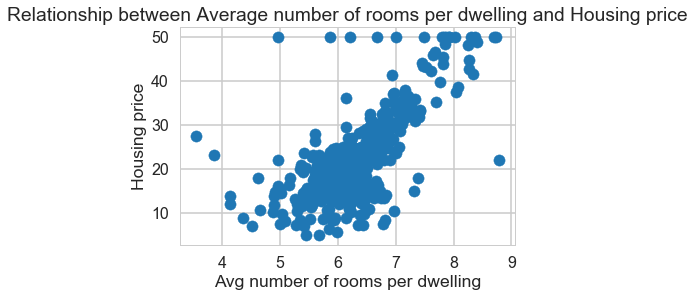

In [45]:
# your turn: scatter plot between *RM* and *PRICE*
plt.scatter(bos.RM, bos.PRICE)
plt.xlabel('Avg number of rooms per dwelling')
plt.ylabel('Housing price')
plt.title('Relationship between Average number of rooms per dwelling and Housing price')

Text(0.5,1,'Relationship between PTRATIO and PRICE')

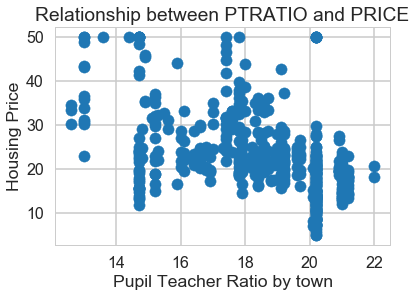

In [46]:
# your turn: scatter plot between *PTRATIO* and *PRICE*
plt.scatter(bos.PTRATIO,bos.PRICE)
plt.xlabel('Pupil Teacher Ratio by town')
plt.ylabel('Housing Price')
plt.title('Relationship between PTRATIO and PRICE')

Text(0.5,1,'Relationship between Portion of Blacks in town and PRICE')

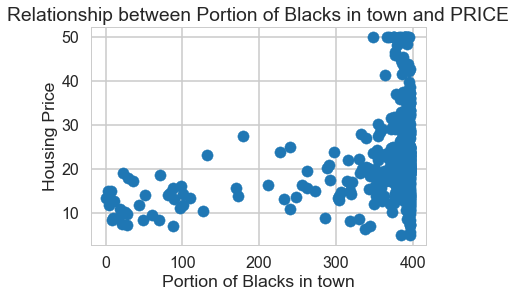

In [47]:
# your turn: create some other scatter plots
# your turn: scatter plot between *Blacks* and *PRICE*
plt.scatter(bos.B,bos.PRICE)
plt.xlabel('Portion of Blacks in town')
plt.ylabel('Housing Price')
plt.title('Relationship between Portion of Blacks in town and PRICE')

Text(0.5,1,'Relationship between Index of accessibility and PRICE')

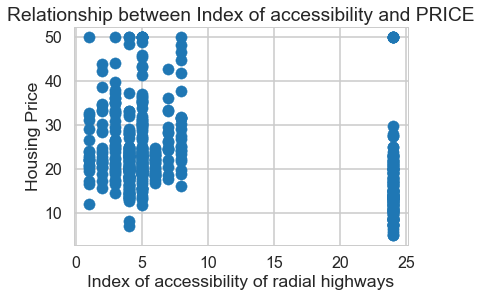

In [48]:
# your turn: create some other scatter plots
# your turn: scatter plot between *RAD* and *PRICE*
plt.scatter(bos.RAD,bos.PRICE)
plt.xlabel('Index of accessibility of radial highways')
plt.ylabel('Housing Price')
plt.title('Relationship between Index of accessibility and PRICE')

Text(0.5,1,'Relationship between Index of accessibility and PRICE')

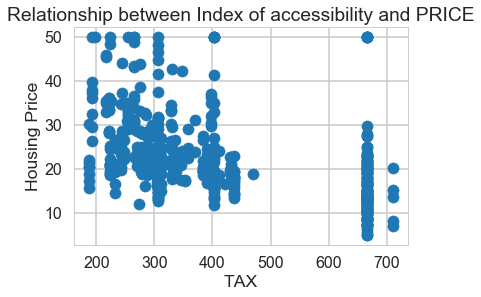

In [49]:
# your turn: create some other scatter plots
# your turn: scatter plot between *TAX* and *PRICE*
plt.scatter(bos.TAX,bos.PRICE)
plt.xlabel('TAX')
plt.ylabel('Housing Price')
plt.title('Relationship between Index of accessibility and PRICE')

Text(0.5,1,'Relationship between % lower status of the population and PRICE')

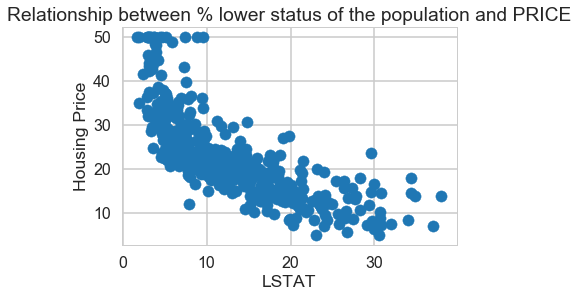

In [50]:
# your turn: create some other scatter plots
# your turn: scatter plot between *LSTAT* and *PRICE*
plt.scatter(bos.LSTAT,bos.PRICE)
plt.xlabel('LSTAT')
plt.ylabel('Housing Price')
plt.title('Relationship between % lower status of the population and PRICE')

### Scatterplots using Seaborn
***

[Seaborn](https://stanford.edu/~mwaskom/software/seaborn/) is a cool Python plotting library built on top of matplotlib. It provides convenient syntax and shortcuts for many common types of plots, along with better-looking defaults.

We can also use [seaborn regplot](https://stanford.edu/~mwaskom/software/seaborn/tutorial/regression.html#functions-to-draw-linear-regression-models) for the scatterplot above. This provides automatic linear regression fits (useful for data exploration later on). Here's one example below.

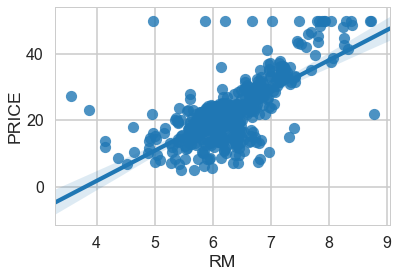

In [51]:
sns.regplot(y="PRICE", x="RM", data=bos, fit_reg = True)

### Histograms
***


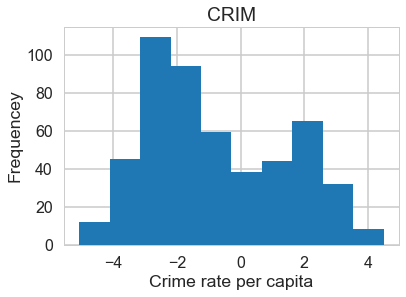

In [52]:
plt.hist(np.log(bos.CRIM))
plt.title("CRIM")
plt.xlabel("Crime rate per capita")
plt.ylabel("Frequencey")
plt.show()

<div class="span5 alert alert-info">
<h3>Part 2 Checkup Exercise Set II</h3>

<p><b>Exercise:</b> In the above histogram, we took the logarithm of the crime rate per capita. Repeat this histogram without taking the log. What was the purpose of taking the log? What do we gain by making this transformation? What do you now notice about this variable that is not obvious without making the transformation?

<p><b>Exercise:</b> Plot histograms for *RM* and *PTRATIO*, along with the two variables you picked in the previous section.</p>
</div>

Applying log basically reduces the data sets to a more manageable small units. If the real values are too close, 
it becomes difficult for the graph to create the bins for plotting purposes. But by reducing them to a much smaller 
values, it becomes easy to plot them as they can be comfortably fit in to more bins.

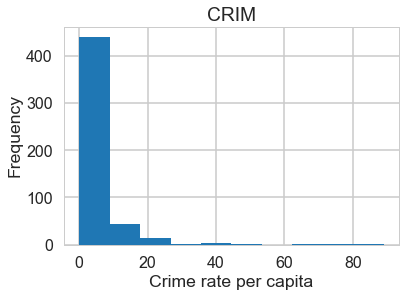

In [54]:
#your turn
plt.hist(bos.CRIM)
plt.title("CRIM")
plt.xlabel("Crime rate per capita")
plt.ylabel("Frequency")
plt.show()

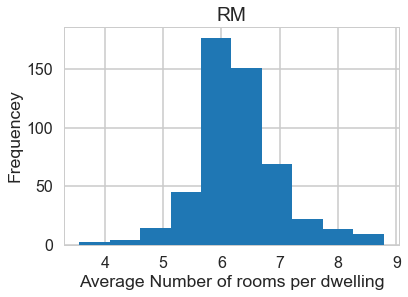

In [55]:
#your turn
plt.hist(bos.RM)
plt.title("RM")
plt.xlabel("Average Number of rooms per dwelling")
plt.ylabel("Frequencey")
plt.show()

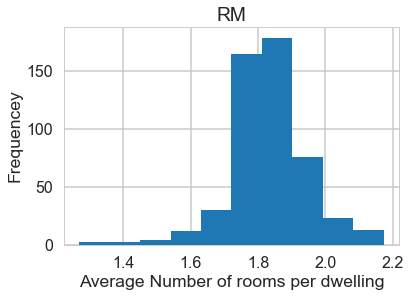

In [56]:
#your turn
plt.hist(np.log(bos.RM))
plt.title("RM")
plt.xlabel("Average Number of rooms per dwelling")
plt.ylabel("Frequencey")
plt.show()

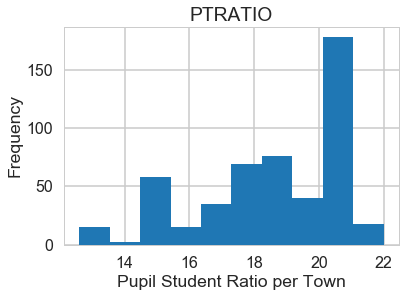

In [57]:
#your turn
plt.hist(bos.PTRATIO)
#plt.hist(np.log(bos.PTRATIO))
plt.title("PTRATIO")
plt.xlabel("Pupil Student Ratio per Town")
plt.ylabel("Frequency")
plt.show()

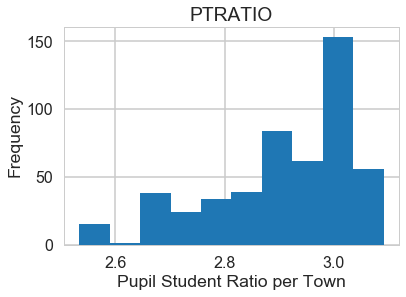

In [58]:
#your turn
plt.hist(np.log(bos.PTRATIO))
plt.title("PTRATIO")
plt.xlabel("Pupil Student Ratio per Town")
plt.ylabel("Frequency")
plt.show()

## Part 3: Linear Regression with Boston Housing Data Example
***

Here, 

$Y$ = boston housing prices (called "target" data in python, and referred to as the dependent variable or response variable)

and

$X$ = all the other features (or independent variables, predictors or explanatory variables)

which we will use to fit a linear regression model and predict Boston housing prices. We will use the least-squares method to estimate the coefficients.  

We'll use two ways of fitting a linear regression. We recommend the first but the second is also powerful in its features.

### Fitting Linear Regression using `statsmodels`
***
[Statsmodels](http://statsmodels.sourceforge.net/) is a great Python library for a lot of basic and inferential statistics. It also provides basic regression functions using an R-like syntax, so it's commonly used by statisticians. While we don't cover statsmodels officially in the Data Science Intensive workshop, it's a good library to have in your toolbox. Here's a quick example of what you could do with it. The version of least-squares we will use in statsmodels is called *ordinary least-squares (OLS)*. There are many other versions of least-squares such as [partial least squares (PLS)](https://en.wikipedia.org/wiki/Partial_least_squares_regression) and [weighted least squares (WLS)](https://en.wikipedia.org/wiki/Iteratively_reweighted_least_squares).

In [384]:
# Import regression modules
import statsmodels.api as sm
from statsmodels.formula.api import ols


In [64]:
# statsmodels works nicely with pandas dataframes
# The thing inside the "quotes" is called a formula, a bit on that below
m = ols('PRICE ~ RM',bos).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     471.8
Date:                Wed, 25 Apr 2018   Prob (F-statistic):           2.49e-74
Time:                        19:27:29   Log-Likelihood:                -1673.1
No. Observations:                 506   AIC:                             3350.
Df Residuals:                     504   BIC:                             3359.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -34.6706      2.650    -13.084      0.0

#### Interpreting coefficients

There is a ton of information in this output. But we'll concentrate on the coefficient table (middle table). We can interpret the `RM` coefficient (9.1021) by first noticing that the p-value (under `P>|t|`) is so small, basically zero. This means that the number of rooms, `RM`, is a statisticall significant predictor of `PRICE`. The regression coefficient for `RM` of 9.1021 means that *on average, each additional room is associated with an increase of $\$9,100$ in house price net of the other variables*. The confidence interval gives us a range of plausible values for this average change, about ($\$8,279, \$9,925$), definitely not chump change. 

In general, the $\hat{\beta_i}, i > 0$ can be interpreted as the following: "A one unit increase in $x_i$ is associated with, on average, a $\hat{\beta_i}$ increase/decrease in $y$ net of all other variables."

On the other hand, the interpretation for the intercept, $\hat{\beta}_0$ is the average of $y$ given that all of the independent variables $x_i$ are 0.

####  `statsmodels` formulas
***
This formula notation will seem familiar to `R` users, but will take some getting used to for people coming from other languages or are new to statistics.

The formula gives instruction for a general structure for a regression call. For `statsmodels` (`ols` or `logit`) calls you need to have a Pandas dataframe with column names that you will add to your formula. In the below example you need a pandas data frame that includes the columns named (`Outcome`, `X1`,`X2`, ...), but you don't need to build a new dataframe for every regression. Use the same dataframe with all these things in it. The structure is very simple:

`Outcome ~ X1`

But of course we want to to be able to handle more complex models, for example multiple regression is doone like this:

`Outcome ~ X1 + X2 + X3`

In general, a formula for an OLS multiple linear regression is

`Y ~ X1 + X2 + ... + Xp`

This is the very basic structure but it should be enough to get you through the homework. Things can get much more complex. You can force statsmodels to treat variables as categorical with the `C()` function, call numpy functions to transform data such as `np.log` for extremely-skewed data, or fit a model without an intercept by including `- 1` in the formula. For a quick run-down of further uses see the `statsmodels` [help page](http://statsmodels.sourceforge.net/devel/example_formulas.html).


Let's see how our model actually fit our data. We can see below that there is a ceiling effect, we should probably look into that. Also, for large values of $Y$ we get underpredictions, most predictions are below the 45-degree gridlines. 

<div class="span5 alert alert-info">
<h3>Part 3 Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a scatterplot between the predicted prices, available in `m.fittedvalues` (where `m` is the fitted model) and the original prices. How does the plot look? Do you notice anything interesting or weird in the plot? Comment on what you see.</p>
</div>

#It's a positive coorelation between the two variables. 
The relationship is almost linear with the exception of outliers which are few and far between

Text(0,0.5,'Original Price')

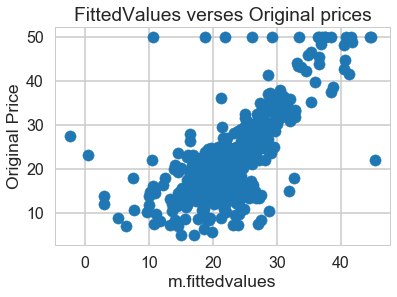

In [61]:
# your turn
plt.subplot(1,1,1)
#sns.regplot(y=bos.PRICE,x=m.fittedvalues, fit_reg = True)
#plt.subplot(1,2,2)
plt.scatter(m.fittedvalues,bos.PRICE)
plt.title('FittedValues verses Original prices')
plt.xlabel('m.fittedvalues')
plt.ylabel('Original Price')

### Fitting Linear Regression using `sklearn`


In [65]:
from sklearn.linear_model import LinearRegression
X = bos.drop('PRICE', axis = 1)

# This creates a LinearRegression object
lm = LinearRegression()
lm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

#### What can you do with a LinearRegression object? 
***
Check out the scikit-learn [docs here](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). We have listed the main functions here. Most machine learning models in scikit-learn follow this same API of fitting a model with `fit`, making predictions with `predict` and the appropriate scoring function `score` for each model.

Main functions | Description
--- | --- 
`lm.fit()` | Fit a linear model
`lm.predit()` | Predict Y using the linear model with estimated coefficients
`lm.score()` | Returns the coefficient of determination (R^2). *A measure of how well observed outcomes are replicated by the model, as the proportion of total variation of outcomes explained by the model*

#### What output can you get?

In [66]:
# Look inside lm object
# lm.<tab>

Output | Description
--- | --- 
`lm.coef_` | Estimated coefficients
`lm.intercept_` | Estimated intercept 

### Fit a linear model
***

The `lm.fit()` function estimates the coefficients the linear regression using least squares. 

In [102]:
# Use all 13 predictors to fit linear regression model
lm.fit(X, bos.PRICE)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

<div class="span5 alert alert-info">
<h3>Part 3 Checkup Exercise Set II</h3>

<p><b>Exercise:</b> How would you change the model to not fit an intercept term? Would you recommend not having an intercept? Why or why not? For more information on why to include or exclude an intercept, look [here](https://online.stat.psu.edu/~ajw13/stat501/SpecialTopics/Reg_thru_origin.pdf).</p>

<p><b>Exercise:</b> One of the assumptions of the linear model is that the residuals must be i.i.d. (independently and identically distributed). To satisfy this, is it enough that the residuals are normally distributed? Explain your answer.</p>

<p><b>Exercise:</b> True or false. To use linear regression, $Y$ must be normally distributed. Explain your answer.</p>
</div>


### Answer
<p><b>Exercise:</b> How would you change the model to not fit an intercept term? 
RTO.By making all the independent variables (X's) 
equal to Zero or subtracting the mean (or a different statistic) from all the independant variables and making the regression line
pass through Zero, we can change the model not fit an intercept term
                                                                                                      
Would you recommend not having an intercept? Why or why not?
This is situational and totaly depends on how linearity varies when the data points are far or close to zero.
A data set which has a linear behavior when the data points are far from zero might have discontinuity around zero. So the
intercept might not be an accurate value. So having a interecept might actually help in understand the data.
In other cases if the data is linear very close to the zero, an intercept migh                                                                                                     

<p><b>Exercise:</b> One of the assumptions of the linear model is that the residuals must be i.i.d. (independently and identically distributed). To satisfy this, is it enough that the residuals are normally distributed? Explain your answer.</p>

No. The i.i.d behaviour and the normal distibution cannot be tied up together because of the variance. One of the assumptions of the liner model is that the data has uniform variance. But a normal distribnutions might have subsets of data which are normally distributed but with differente variances. So i.i.d does not mean that the data is normal.

<p><b>Exercise:</b> True or false. To use linear regression, $Y$ must be normally distributed. Explain your answer.</p>
</div>

No. Y may or not be normally distributed and is not needed to be normal. This does not influence the liner regression in anyway. The only underlying assumptions needed are the resudials are independant and identically distributed. 

### Estimated intercept and coefficients

Let's look at the estimated coefficients from the linear model using `1m.intercept_` and `lm.coef_`.  

After we have fit our linear regression model using the least squares method, we want to see what are the estimates of our coefficients $\beta_0$, $\beta_1$, ..., $\beta_{13}$: 

$$ \hat{\beta}_0, \hat{\beta}_1, \ldots, \hat{\beta}_{13} $$



In [72]:
print('Estimated intercept coefficient: {}'.format(lm.intercept_))

Estimated intercept coefficient: 36.491103280364015


In [99]:
print('Number of coefficients: {}'.format(len(lm.coef_)))

Number of coefficients: 13


In [100]:
# The coefficients
pd.DataFrame({'features': X.columns, 'estimatedCoefficients': lm.coef_})[['features', 'estimatedCoefficients']]

,features,estimatedCoefficients
0,CRIM,-0.107171
1,ZN,0.046395
2,INDUS,0.020860
3,CHAS,2.688561
4,NOX,-17.795759
5,RM,3.804752
6,AGE,0.000751
7,DIS,-1.475759
8,RAD,0.305655
9,TAX,-0.012329


### Predict Prices 

We can calculate the predicted prices ($\hat{Y}_i$) using `lm.predict`. 

$$ \hat{Y}_i = \hat{\beta}_0 + \hat{\beta}_1 X_1 + \ldots \hat{\beta}_{13} X_{13} $$

In [101]:
# first five predicted prices
lm.predict(X)[0:5]

array([ 30.00821269,  25.0298606 ,  30.5702317 ,  28.60814055,  27.94288232])

<div class="span5 alert alert-info">
<h3>Part 3 Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Histogram: Plot a histogram of all the predicted prices. Write a story about what you see. Describe the shape, center and spread of the distribution. Are there any outliers? What might be the reason for them? Should we do anything special with them?</p>

<p><b>Exercise:</b> Scatterplot: Let's plot the true prices compared to the predicted prices to see they disagree (we did this with `statsmodels` before).</p>

<p><b>Exercise:</b> We have looked at fitting a linear model in both `statsmodels` and `scikit-learn`. What are the advantages and disadvantages of each based on your exploration? Based on the information provided by both packages, what advantage does `statsmodels` provide?</p>
</div>

<p><b>Exercise:</b> Histogram: Plot a histogram of all the predicted prices. Write a story about what you see. Describe the shape, center and spread of the distribution. Are there any outliers? What might be the reason for them? Should we do anything special with them?

The shape of the graph is symmetric which shows the predicted prices are symmetric around the mean.They go up till the mean value is reached and then the start falling down. 
Shape of the curve is symmetric. So we can take the center as mean. We can use the standard deviation for the spread. 

Text(0,0.5,'Values')

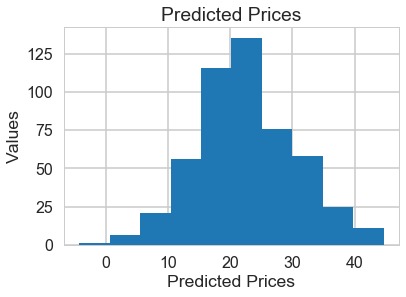

In [103]:
# your turn HISTOGRAM 
plt.hist(lm.predict(X))
plt.title('Predicted Prices')
plt.xlabel('Predicted Prices')
plt.ylabel('Values')

<p><b>Exercise:</b> Scatterplot: Let's plot the true prices compared to the predicted prices to see they disagree (we did this with `statsmodels` before).</p>

Text(0,0.5,'Original Price')

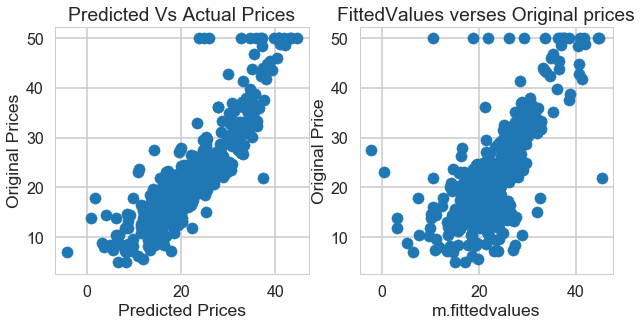

In [104]:
# your turn SCATTER
f = plt.figure(figsize=(10,10))
#plt.subplot(2,2, 1,figsize=(15,15))
ax = f.add_subplot(221).scatter(lm.predict(X),bos.PRICE)
plt.title('Predicted Vs Actual Prices')
plt.xlabel('Predicted Prices')
plt.ylabel('Original Prices')
# your turn
#plt.subplot(222)
ax2 = f.add_subplot(222).scatter(m.fittedvalues,bos.PRICE)
plt.title('FittedValues verses Original prices')
plt.xlabel('m.fittedvalues')
plt.ylabel('Original Price')

Text(0,0.5,'Original Price')

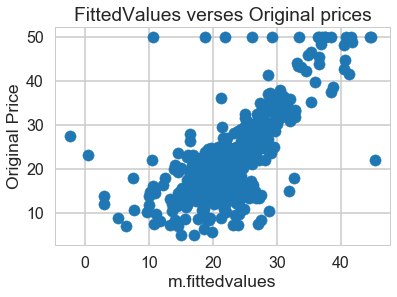

In [105]:
# your turn
plt.scatter(m.fittedvalues,bos.PRICE)
plt.title('FittedValues verses Original prices')
plt.xlabel('m.fittedvalues')
plt.ylabel('Original Price')

Exercise: We have looked at fitting a linear model in both statsmodels and scikit-learn. What are the advantages and disadvantages of each based on your exploration? Based on the information provided by both packages, what advantage does statsmodels provide?

Answer: Advantages is that scikit-learn is easier to implement, easier to learn and is more suited to machine learning. It has better documentation and much larger support base as it's been there lot longer than stats models. It's more Pythonic in it's approach while Stats models has more statistics to it. Disadvantages of Scikit learn is very good for basic statistics but if one want so use it for other diagnostic values, you have to write your own code or move to Stats models. 
Advantages of stats models is that it offers more indepth statistics analysis. It has an interface much closer to R, so it makes it easier for folks to transition from Python to R. Basic summary of stats models has lot more diagonistic values than what scikit offers.  Disadvantages of stats model is that it is a newer package and there are many bugs in the package as is common with newer packages. It has much less support in terms of number of developers working on it and the documentation is sparse too.

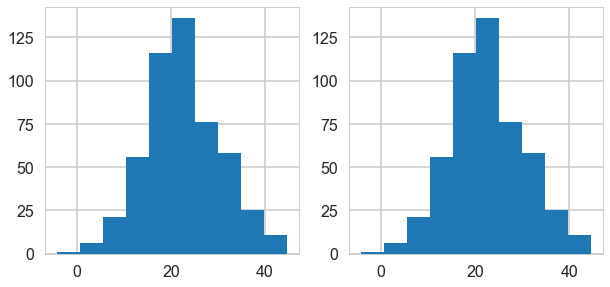

In [124]:
f=plt.figure(figsize=(10,10))
ax3 = f.add_subplot(221).hist(lm.predict(X))
n=ols('PRICE~CRIM+ZN+INDUS+CHAS+NOX+RM+AGE+DIS+RAD+TAX+PTRATIO+B+LSTAT',bos).fit().fittedvalues
ax4=f.add_subplot(222).hist(n)

In [125]:
ols('PRICE~CRIM+ZN+INDUS+CHAS+NOX+RM+AGE+DIS+RAD+TAX+PTRATIO+B+LSTAT',bos).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  PRICE   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Fri, 27 Apr 2018   Prob (F-statistic):          6.95e-135
Time:                        20:17:02   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     36.4911      5.104      7.149      0.000      26.462      46.520
CRIM          -0.1072      0.033     -3.276      0.001      -0.171      -0.043
ZN             0.0464      0.014      3.380      0.001       0.019       0.073
INDUS          0.0209      0.061      0.339      0.735      -0.100       0.142
CHAS           2.6886      0.862      3.120      0.002       0.996       4.381
NOX          -17.7958      3.821     -4.658      0.000     -25.302     -10.289
RM             3.8048      0.418      9.102      0.000       2.983       4.626
AGE            0.0008      0.013      0.057      0.955      -0.025       0.027
DIS           -1.4758      0.199     -7.398      0.000      -1.868      -1.084
RAD            0.3057      0.066      4.608      0.000       0.175       0.436
TAX           -0.0123      0.004     -3.278      0.001      -0.020      -0.005
PTRATIO       -0.9535      0.131     -7.287      0.000      -1.211      -0.696
B              0.0094      0.003      3.500      0.001       0.004       0.015
LSTAT         -0.5255      0.051    -10.366      0.000      -0.625      -0.426
==============================================================================
Omnibus:                      178.029   Durbin-Watson:                   1.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              782.015
Skew:                           1.521   Prob(JB):                    1.54e-170
Kurtosis:                       8.276   Cond. No.                     1.51e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Evaluating the Model: Sum-of-Squares

The partitioning of the sum-of-squares shows the variance in the predictions explained by the model and the variance that is attributed to error.

$$TSS = ESS + RSS$$

#### Residual Sum-of-Squares (aka $RSS$)

The residual sum-of-squares is one of the basic ways of quantifying how much error exists in the fitted model. We will revisit this in a bit.

$$ RSS = \sum_{i=1}^N r_i^2 = \sum_{i=1}^N \left(y_i - \left(\beta_0 + \beta_1 x_i\right)\right)^2 $$

In [126]:
print(np.sum((bos.PRICE - lm.predict(X)) ** 2))

11080.276284149872


#### Explained Sum-of-Squares (aka $ESS$)

The explained sum-of-squares measures the variance explained by the regression model.

$$ESS = \sum_{i=1}^N \left( \hat{y}_i - \bar{y} \right)^2 = \sum_{i=1}^N \left( \left( \hat{\beta}_0 + \hat{\beta}_1 x_i \right) - \bar{y} \right)^2$$

In [127]:
print(np.sum(lm.predict(X) - np.mean(bos.PRICE)) ** 2)

5.80189651524e-23


### Evaluating the Model: The Coefficient of Determination ($R^2$)

The coefficient of determination, $R^2$, tells us the percentage of the variance in the response variable $Y$ that can be explained by the linear regression model.

$$ R^2 = \frac{ESS}{TSS} $$

The $R^2$ value is one of the most common metrics that people use in describing the quality of a model, but it is important to note that *$R^2$ increases artificially as a side-effect of increasing the number of independent variables.* While $R^2$ is reported in almost all statistical packages, another metric called the *adjusted $R^2$* is also provided as it takes into account the number of variables in the model, and can sometimes even be used for non-linear regression models!

$$R_{adj}^2 = 1 - \left( 1 - R^2 \right) \frac{N - 1}{N - K - 1} = R^2 - \left( 1 - R^2 \right) \frac{K}{N - K - 1} = 1 - \frac{\frac{RSS}{DF_R}}{\frac{TSS}{DF_T}}$$

where $N$ is the number of observations, $K$ is the number of variables, $DF_R = N - K - 1$ is the degrees of freedom associated with the residual error and $DF_T = N - 1$ is the degrees of the freedom of the total error.

### Evaluating the Model: Mean Squared Error and the $F$-Statistic
***
The mean squared errors are just the *averages* of the sum-of-squares errors over their respective degrees of freedom.

$$MSE = \frac{ESS}{K}$$
$$MSR = \frac{RSS}{N-K-1}$$

**Remember: ** Notation may vary across resources particularly the use of *R* and *E* in *RSS/ESS* and *MSR/MSE*. In some resources, E = explained and R = residual. In other resources, E = error and R = regression (explained). **This is a very important distinction that requires looking at the formula to determine which naming scheme is being used.**

Given the MSR and MSE, we can now determine whether or not the entire model we just fit is even statistically significant. We use an $F$-test for this. The null hypothesis is that all of the $\beta$ coefficients are zero, that is, none of them have any effect on $Y$. The alternative is that *at least one* $\beta$ coefficient is nonzero, but it doesn't tell us which one in a multiple regression:

$$H_0: \beta_i = 0, \mbox{for all $i$} \\
H_A: \beta_i > 0, \mbox{for some $i$}$$ 

$$F = \frac{MSR}{MSE} = \left( \frac{R^2}{1 - R^2} \right) \left( \frac{N - K - 1}{K} \right)$$
 
Once we compute the $F$-statistic, we can use the $F$-distribution with $N-K$ and $K-1$ degrees of degrees of freedom to get a p-value.

**Warning!** The $F$-statistic mentioned in this section is NOT the same as the F1-measure or F1-value discused in Unit 7.

<div class="span5 alert alert-info">
<h3>Part 3 Checkup Exercise Set IV</h3>

<p>Let's look at the relationship between `PTRATIO` and housing price.</p>

<p><b>Exercise:</b> Make a scatterplot of `PTRATIO` and housing price. Tell a story about the relationship between the variables.</p>

<p><b>Exercise:</b> Try fitting a linear regression model using only the 'PTRATIO' (pupil-teacher ratio by town) and interpret the intercept and the coefficients.</p>

<p><b>Exercise:</b> Calculate (or extract) the $R^2$ value. What does it tell you?</p>

<p><b>Exercise:</b> Compute the $F$-statistic. What does it tell you?</p>

<p><b>Exercise:</b> Take a close look at the $F$-statistic and the $t$-statistic for the regression coefficient. What relationship do you notice? Note that this relationship only applies in *simple* linear regression models.</p>
</div>

<p>Let's look at the relationship between `PTRATIO` and housing price.</p>

<p><b>Exercise:</b> Make a scatterplot of `PTRATIO` and housing price. Tell a story about the relationship between the variables.</p>

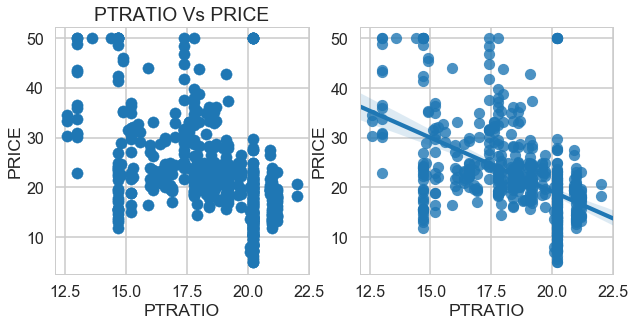

In [237]:
# your turn
f=plt.figure(figsize=(10,10))
ax=f.add_subplot(221).scatter(bos.PTRATIO,bos.PRICE)
plt.title('PTRATIO Vs PRICE')
plt.xlabel('PTRATIO')
plt.ylabel('PRICE')
ax1=f.add_subplot(222)
sns.regplot(y='PRICE',x='PTRATIO',data=bos,fit_reg=True)

<p><b>Exercise:</b> Make a scatterplot of `PTRATIO` and housing price. Tell a story about the relationship between the variables.</p>

Answer: As thhe PTRATIO inreases, PRICE is is falling showing a negative coorelation. It makes sense because the pricier neighbourhoods cannot afford better or richer schools which many people cannot afford pushing the PTRATIO higher.There is significant outliers but that might be due a

<p><b>Exercise:</b> Try fitting a linear regression model using only the 'PTRATIO' (pupil-teacher ratio by town) and interpret the intercept and the coefficients.</p>

<p><b>Exercise:</b> Calculate (or extract) the $R^2$ value. What does it tell you?</p>
Answer: R^2 value is 0.258 which explains around 25% of the variance of the dependant variable(pricing) around the mean. But this is not enough to conclude whether it is a good fit or a bad fit. R^2 provides an estimate of the strength of the relationship between the model and the response variable (Price) but does not provide any means to test that relationship.   

<p><b>Exercise:</b> Compute the $F$-statistic. What does it tell you?</p>F-statistic is 175.10 with a p-value is 1.60e-34 which is very close to Zero.Assuming a significance value of 0.05, we can reject the null hypothesis that the predictor variable (PTRATIO) is statistically insignificant. PTRATIO is playing a significant role in the determination of the Y variable and contributes to 25% varation of the Pricing around the mean.

In [268]:
ptratio_array=np.array(bos.PTRATIO).reshape(len(bos.PTRATIO),1)
ln=LinearRegression()
ln.fit(ptratio_array,bos.PRICE)
price_pred=ln.predict(ptratio_array)
mse=mean_squared_error(b_pred,bos.PRICE)
print('Mean Squared Error is:{}'.format(mean_squared_error(bos.PRICE,price_pred)))
print('Coefficient of Determination R^2 is:{}'.format(r2_score(bos.PRICE,price_pred)))
print('Coefficient of the Regression is:{}'.format(ln.coef_))
print('F Statistic is:{}'.format(f_regression(ptratio_array,bos.PRICE)))
print('Y Intercept of the Regression is:{}'.format(ln.intercept_))

Mean Squared Error is:62.65220001376927
Coefficient of Determination R^2 is:0.257847318009223
Coefficient of the Regression is:[-2.1571753]
F Statistic is:(array([ 175.10554288]), array([  1.60950948e-34]))
Y Intercept of the Regression is:62.34462747483266


In [307]:
type(price_pred)

numpy.ndarray

In [221]:
ols('PRICE~PTRATIO',bos).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  PRICE   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     175.1
Date:                Sun, 29 Apr 2018   Prob (F-statistic):           1.61e-34
Time:                        12:30:03   Log-Likelihood:                -1764.8
No. Observations:                 506   AIC:                             3534.
Df Residuals:                     504   BIC:                             3542.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     62.3446      3.029     20.581      0.000      56.393      68.296
PTRATIO       -2.1572      0.163    -13.233      0.000      -2.477      -1.837
==============================================================================
Omnibus:                       92.924   Durbin-Watson:                   0.725
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              191.444
Skew:                           1.001   Prob(JB):                     2.68e-42
Kurtosis:                       5.252   Cond. No.                         160.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

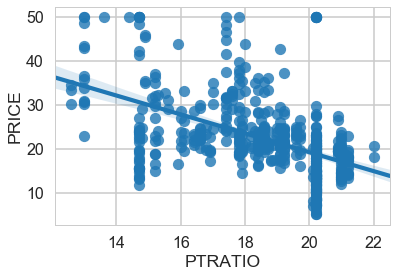

In [240]:
sns.regplot(y="PRICE", x="PTRATIO", data=bos, fit_reg = True)

<div class="span5 alert alert-info">
<h3>Part 3 Checkup Exercise Set V</h3>

<p>Fit a linear regression model using three independent variables</p>

<ol>
<li> 'CRIM' (per capita crime rate by town)
<li> 'RM' (average number of rooms per dwelling)
<li> 'PTRATIO' (pupil-teacher ratio by town)
</ol>

<p><b>Exercise:</b> Compute or extract the $F$-statistic. What does it tell you about the model?</p>


<p><b>Exercise:</b> Compute or extract the $R^2$ statistic. What does it tell you about the model?</p>

<p><b>Exercise:</b> Which variables in the model are significant in predicting house price? Write a story that interprets the coefficients.</p>
</div>

In [370]:
bos_crp=bos[["CRIM","RM","PTRATIO"]]
bos_price=np.array(bos.PRICE.values).reshape(len(bos.PRICE),1)
lm=LinearRegression()
crp_fit=lm.fit(bos_crp,bos.PRICE)
crp_pred=lm.predict(bos_crp)
crp_pred=crp_pred.reshape(len(crp_pred),1)
print('Mean Squared Error: {}'.format(mean_squared_error(bos_price,crp_pred)))
print('Coefficient of Determination(R^2):{}'.format(r2_score(bos_price,crp_pred)))
print('Coefficient of Regression:{}'.format(lm.coef_))
print('Intercept of Regression:{}'.format(lm.intercept_))
print('F Statistic:{}'.format(f_regression(bos_price,crp_pred)))

Mean Squared Error: 34.323796564681196
Coefficient of Determination(R^2):0.5934141551136979
Coefficient of Regression:[-0.20210971  7.3815667  -1.0741868 ]
Intercept of Regression:-3.3066171324064975
F Statistic:(array([ 735.59062112]), array([  1.47778932e-100]))


C:\Users\habsa\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [367]:
ols('PRICE~CRIM+RM+PTRATIO',bos).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  PRICE   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     244.2
Date:                Mon, 30 Apr 2018   Prob (F-statistic):           1.09e-97
Time:                        21:18:35   Log-Likelihood:                -1612.6
No. Observations:                 506   AIC:                             3233.
Df Residuals:                     502   BIC:                             3250.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.3066      4.038     -0.819      0.413     -11.240       4.627
CRIM          -0.2021      0.032     -6.301      0.000      -0.265      -0.139
RM             7.3816      0.402     18.360      0.000       6.592       8.171
PTRATIO       -1.0742      0.133     -8.081      0.000      -1.335      -0.813
==============================================================================
Omnibus:                      233.249   Durbin-Watson:                   0.828
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2002.374
Skew:                           1.802   Prob(JB):                         0.00
Kurtosis:                      12.054   Cond. No.                         311.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Part 4: Comparing Models

During modeling, there will be times when we want to compare models to see which one is more predictive or fits the data better. There are many ways to compare models, but we will focus on two.

### The $F$-Statistic Revisited

The $F$-statistic can also be used to compare two *nested* models, that is, two models trained on the same dataset where one of the models contains a *subset* of the variables of the other model. The *full* model contains $K$ variables and the *reduced* model contains a subset of these $K$ variables. This allows us to add additional variables to a base model and then test if adding the variables helped the model fit.

$$F = \frac{\left( \frac{RSS_{full} - RSS_{reduced}}{K_{full} - K_{reduced}} \right)}{\left( \frac{RSS_{reduced}}{N - K_{reduced}} \right)}$$

### Akaike Information Criterion (AIC)

Another statistic for comparing two models is AIC, which is based on the likelihood function and takes into account the number of variables in the model.

$$AIC = 2 K - 2 \log_e{L}$$

where $L$ is the likelihood of the model. AIC is meaningless in the absolute sense, and is only meaningful when compared to AIC values from other models. Lower values of AIC indicate better fitting models.

`statsmodels` provides the AIC in its output.

<div class="span5 alert alert-info">
<h3>Part 4 Checkup Exercises</h3>

<p><b>Exercise:</b> Find another variable (or two) to add to the model we built in Part 3. Compute the $F$-test comparing the two models as well as the AIC. Which model is better?</p>
</div>

Answer: The newer model is better becasue R^2 value has increased to 67% and the probability of F-statistic is still very close to Zero. So the newer model is better.

In [382]:
bos_crp=bos[["CRIM","RM","PTRATIO","LSTAT","TAX"]]
bos_price=np.array(bos.PRICE.values).reshape(len(bos.PRICE),1)
lm=LinearRegression()
crp_fit=lm.fit(bos_crp,bos.PRICE)
crp_pred=lm.predict(bos_crp)
crp_pred=crp_pred.reshape(len(crp_pred),1)
print('Mean Squared Error: {}'.format(mean_squared_error(bos_price,crp_pred)))
print('Coefficient of Determination(R^2):{}'.format(r2_score(bos_price,crp_pred)))
print('Coefficient of Regression:{}'.format(lm.coef_))
print('Intercept of Regression:{}'.format(lm.intercept_))
print('F Statistic:{}'.format(f_regression(bos_price,crp_pred)))

Mean Squared Error: 26.887148238104498
Coefficient of Determination(R^2):0.6815056905965406
Coefficient of Regression:[ -5.76307787e-02   4.63027171e+00  -8.73397301e-01  -5.28873917e-01
  -8.66244316e-04]
Intercept of Regression:16.804874192604128
F Statistic:(array([ 1078.44585576]), array([  2.60014200e-127]))


C:\Users\habsa\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [383]:
ols('PRICE~CRIM+RM+PTRATIO+LSTAT+TAX',bos).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  PRICE   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     214.0
Date:                Tue, 01 May 2018   Prob (F-statistic):          1.01e-121
Time:                        05:44:31   Log-Likelihood:                -1550.8
No. Observations:                 506   AIC:                             3114.
Df Residuals:                     500   BIC:                             3139.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     16.8049      3.998      4.203      0.000       8.949      24.660
CRIM          -0.0576      0.034     -1.701      0.090      -0.124       0.009
RM             4.6303      0.429     10.789      0.000       3.787       5.473
PTRATIO       -0.8734      0.125     -6.978      0.000      -1.119      -0.627
LSTAT         -0.5289      0.048    -11.020      0.000      -0.623      -0.435
TAX           -0.0009      0.002     -0.449      0.654      -0.005       0.003
==============================================================================
Omnibus:                      224.813   Durbin-Watson:                   0.882
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1290.039
Skew:                           1.877   Prob(JB):                    7.44e-281
Kurtosis:                       9.862   Cond. No.                     7.66e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.66e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [386]:
mod=ols('PRICE~CRIM+RM+PTRATIO+LSTAT+TAX',bos).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

                sum_sq     df           F        PR(>F)
CRIM         78.728105    1.0    2.893374  8.956624e-02
RM         3167.072273    1.0  116.394570  1.542981e-24
PTRATIO    1324.965947    1.0   48.694450  9.540078e-12
LSTAT      3304.301213    1.0  121.437936  1.978465e-25
TAX           5.476539    1.0    0.201271  6.538913e-01
Residual  13604.897008  500.0         NaN           NaN



## Part 5: Evaluating the Model via Model Assumptions and Other Issues
***
Linear regression makes several assumptions. It is always best to check that these assumptions are valid after fitting a linear regression model.

<div class="span5 alert alert-danger">
<ul>
  <li>**Linearity**. The dependent variable $Y$ is a linear combination of the regression coefficients and the independent variables $X$. This can be verified with a scatterplot of each $X$ vs. $Y$ and plotting correlations among $X$. Nonlinearity can sometimes be resolved by [transforming](https://onlinecourses.science.psu.edu/stat501/node/318) one or more independent variables, the dependent variable, or both. In other cases, a [generalized linear model](https://en.wikipedia.org/wiki/Generalized_linear_model) or a [nonlinear model](https://en.wikipedia.org/wiki/Nonlinear_regression) may be warranted.</li>
  <li>**Constant standard deviation**. The SD of the dependent variable $Y$ should be constant for different values of X. We can check this by plotting each $X$ against $Y$ and verifying that there is no "funnel" shape showing data points fanning out as $X$ increases or decreases. Some techniques for dealing with non-constant variance include weighted least squares (WLS), [robust standard errors](https://en.wikipedia.org/wiki/Heteroscedasticity-consistent_standard_errors), or variance stabilizing transformations.
    </li>
  <li> **Normal distribution for errors**.  The $\epsilon$ term we discussed at the beginning are assumed to be normally distributed. This can be verified with a fitted values vs. residuals plot and verifying that there is no pattern, and with a quantile plot.
  $$ \epsilon_i \sim N(0, \sigma^2)$$
Sometimes the distributions of responses $Y$ may not be normally distributed at any given value of $X$.  e.g. skewed positively or negatively. </li>
<li> **Independent errors**.  The observations are assumed to be obtained independently.
    <ul>
        <li>e.g. Observations across time may be correlated
    </ul>
</li>
</ul>  

</div>

There are some other issues that are important investigate with linear regression models.

<div class="span5 alert alert-danger">
<ul>
  <li>**Correlated Predictors:** Care should be taken to make sure that the independent variables in a regression model are not too highly correlated. Correlated predictors typically do not majorly affect prediction, but do inflate standard errors of coefficients making interpretation unreliable. Common solutions are dropping the least important variables involved in the correlations, using regularlization, or, when many predictors are highly correlated, considering a dimension reduction technique such as principal component analysis (PCA).
  <li>**Influential Points:** Data points that have undue influence on the regression model. These points can be high leverage points or outliers. Such points are typically removed and the regression model rerun.
</ul>
</div>


<div class="span5 alert alert-info">
<h3>Part 5 Checkup Exercises</h3>

<p>Take the reduced model from Part 3 to answer the following exercises. Take a look at [this blog post](http://mpastell.com/2013/04/19/python_regression/) for more information on using statsmodels to construct these plots.</p>
    
<p><b>Exercise:</b> Construct a fitted values versus residuals plot. What does the plot tell you? Are there any violations of the model assumptions?</p>

<p><b>Exercise:</b> Construct a quantile plot of the residuals. What does the plot tell you?</p>

<p><b>Exercise:</b> What are some advantages and disadvantages of the fitted vs. residual and quantile plot compared to each other?</p>

<p><b>Exercise:</b> Identify any outliers (if any) in your model and write a story describing what these outliers might represent.</p>

<p><b>Exercise:</b> Construct a leverage plot and identify high leverage points in the model. Write a story explaining possible reasons for the high leverage points.</p>

<p><b>Exercise:</b> Remove the outliers and high leverage points from your model and run the regression again. How do the results change?</p>
</div>

<p><b>Exercise:</b> Construct a fitted values versus residuals plot. What does the plot tell you? Are there any violations of the model assumptions?</p> The plot shows it's not a best fit as the the graph is almost funnel shape indicating that the variance is changing which means that the residuals are not normally distributed.

<p><b>Exercise:</b> Construct a quantile plot of the residuals. What does the plot tell you?</p>
Quantile plot indicates that the residuals are deviating from the 45 degree line indicating not a good fit. Either the data we have is insifficient or we need more variables to do more accurate prediction.


In [477]:
# Your turn.
crt_fit=ols('PRICE~CRIM+RM+PTRATIO',bos).fit()
crt_fit_vals=crt_fit.fittedvalues
crt_res=crt_fit.resid

Text(0,0.5,'Residuals')

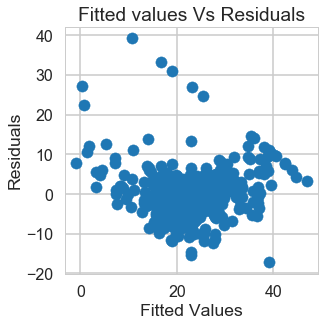

In [500]:
f=plt.figure(figsize=(10,10))
#ax1=f.add_subplot(221).scatter(crt_fit_vals,crt_res)
f.add_subplot(221).scatter(crt_fit_vals,crt_res)
plt.title("Fitted values Vs Residuals")
plt.xlabel('Fitted Values' )
plt.ylabel('Residuals')
# ax1=f.add_subplot(222)
# sns.regplot(y=crt_res,x=crt_fit_vals,fit_reg=True)
# plt.title("Fitted values Vs Residuals-Reg Plot")
# plt.xlabel('Residuals' )
# plt.ylabel('Fitted Values')
#ax1=f.add_subplot(222)

Text(0,0.5,'Fitted Values')

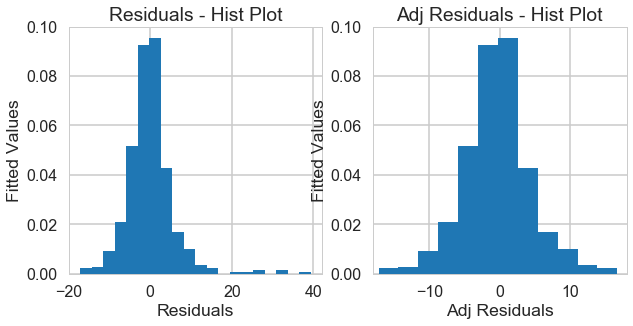

In [499]:
f=plt.figure(figsize=(10,10))
f.add_subplot(221).hist(crt_res,bins=20,normed=True)
plt.title("Residuals - Hist Plot")
plt.xlabel('Residuals' )
plt.ylabel('Fitted Values')
f.add_subplot(222).hist(crt_res,bins=20,normed=True)
plt.xlim(-18,18)
plt.title("Adj Residuals - Hist Plot")
plt.xlabel('Adj Residuals' )
plt.ylabel('Fitted Values')

Text(0,0.5,'Quantiles')

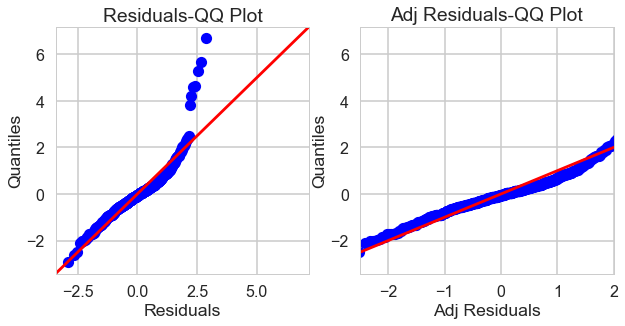

In [497]:
f=plt.figure(figsize=(10,10))
ax=f.add_subplot(221) 
sm.qqplot(crt_res,fit=True,line='45',ax=ax)
plt.title("Residuals-QQ Plot")
plt.xlabel('Residuals')
plt.ylabel('Quantiles')
ax=f.add_subplot(222) 
sm.qqplot(crt_res,fit=True,line='45',ax=ax)
ax.set_xlim(-2.5,2.0)
plt.title("Adj Residuals-QQ Plot")
plt.xlabel('Adj Residuals')
plt.ylabel('Quantiles')

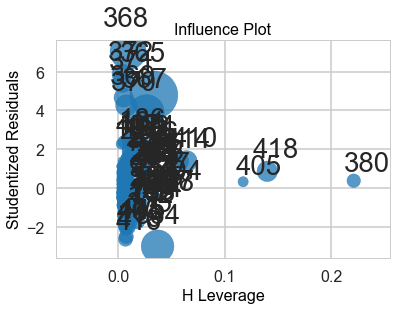

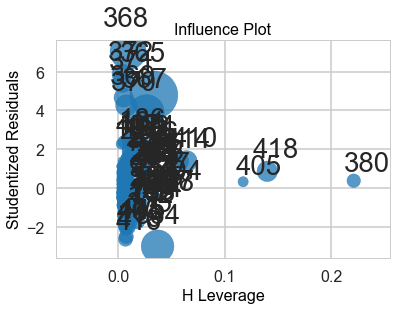

In [498]:
# leverage, from statsmodels internals
crt_leverage = crt_fit.get_influence().hat_matrix_diag
# cook's distance, from statsmodels internals
crt_cooks = crt_fit.get_influence().cooks_distance[0]
sm.graphics.influence_plot(crt_fit, criterion="cooks")

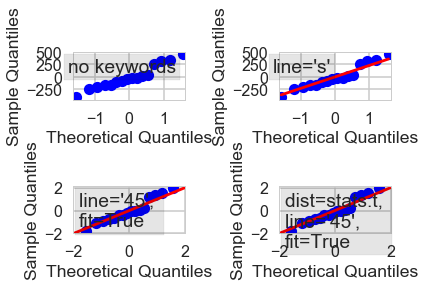

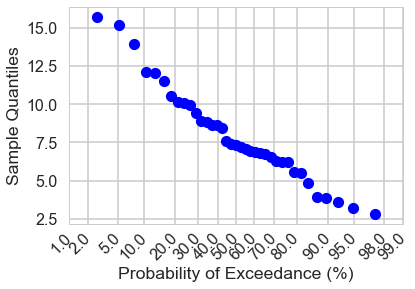

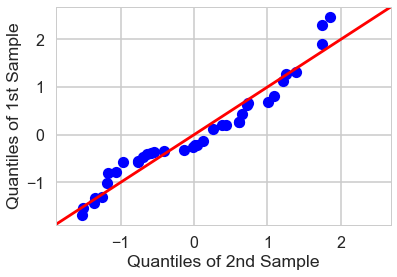

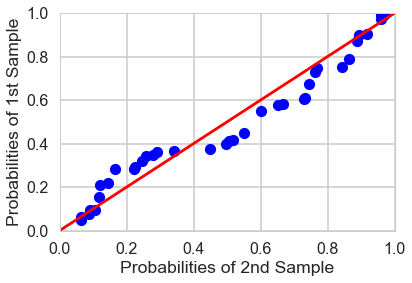

In [495]:
# -*- coding: utf-8 -*-
"""
Created on Sun May 06 05:32:15 2012

Author: Josef Perktold
editted by: Paul Hobson (2012-08-19)
"""
from scipy import stats
from matplotlib import pyplot as plt
import statsmodels.api as sm

#example from docstring

data = sm.datasets.longley.load()
data.exog = sm.add_constant(data.exog, prepend=True)
mod_fit = sm.OLS(data.endog, data.exog).fit()
res = mod_fit.resid

left = -1.8   #x coordinate for text insert

fig = plt.figure()

ax = fig.add_subplot(2, 2, 1)
sm.graphics.qqplot(res, ax=ax)
top = ax.get_ylim()[1] * 0.75
txt = ax.text(left, top, 'no keywords', verticalalignment='top')
txt.set_bbox(dict(facecolor='k', alpha=0.1))

ax = fig.add_subplot(2, 2, 2)
sm.graphics.qqplot(res, line='s', ax=ax)
top = ax.get_ylim()[1] * 0.75
txt = ax.text(left, top, "line='s'", verticalalignment='top')
txt.set_bbox(dict(facecolor='k', alpha=0.1))

ax = fig.add_subplot(2, 2, 3)
sm.graphics.qqplot(res, line='45', fit=True, ax=ax)
ax.set_xlim(-2, 2)
top = ax.get_ylim()[1] * 0.75
txt = ax.text(left, top, "line='45', \nfit=True", verticalalignment='top')
txt.set_bbox(dict(facecolor='k', alpha=0.1))

ax = fig.add_subplot(2, 2, 4)
sm.graphics.qqplot(res, dist=stats.t, line='45', fit=True, ax=ax)
ax.set_xlim(-2, 2)
top = ax.get_ylim()[1] * 0.75
txt = ax.text(left, top, "dist=stats.t, \nline='45', \nfit=True",
              verticalalignment='top')
txt.set_bbox(dict(facecolor='k', alpha=0.1))

fig.tight_layout()

plt.gcf()


# example with the new ProbPlot class
import numpy as np
x = np.random.normal(loc=8.25, scale=3.5, size=37)
y = np.random.normal(loc=8.00, scale=3.25, size=37)
pp_x = sm.ProbPlot(x, fit=True)
pp_y = sm.ProbPlot(y, fit=True)

# probability of exceedance
fig2 = pp_x.probplot(exceed=True)

# compare x quantiles to y quantiles
fig3 = pp_x.qqplot(other=pp_y, line='45')

# same as above with probabilities/percentiles
fig4 = pp_x.ppplot(other=pp_y, line='45')
